Problem Statement:

- Given historical TTC subway service data, can we accurately predict the expected severity of a delay (in terms of minimum delay duration) at a specific station, on a specific line, at a given day, date, and hour?

- What operational and temporal factors most strongly influence the magnitude of transit delays?

In [2]:
# Load important libraries

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin

import pandas as pd
import numpy as np

In [3]:
# Load data with non-zero delays

df = pd.read_csv("./transformed_data_22-24.csv")
# Filter where 'Min Delay' is greater than 0
df = df[df['Min Delay'] > 0].copy()

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 26575 entries, 9 to 69067
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Date                  26575 non-null  object
 1   Time                  26575 non-null  object
 2   Day                   26575 non-null  object
 3   Station               26575 non-null  object
 4   Code                  26575 non-null  object
 5   Code Description      26575 non-null  object
 6   Min Delay             26575 non-null  int64 
 7   Min Gap               26575 non-null  int64 
 8   Line                  26575 non-null  object
 9   Station_Part_Cleaned  26575 non-null  object
 10  Station_Cleaned       26575 non-null  object
 11  Code_Freq             26575 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 2.6+ MB


In [4]:
# Log-transform target

df['Min_Delay_Log'] = np.log1p(df['Min Delay'])


In [5]:
# Extract datatime features

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Month_Num'] = df['Date'].dt.month
df['DateOfMonth'] = df['Date'].dt.day


In [6]:
# Define features and target

features = ['Month_Num', 'DateOfMonth', 'Hour', 'Code_Freq', 'Min Gap', 'Day', 'Line', 'Station_Cleaned']
target = 'Min_Delay_Log'

X = df[features]
y = df[target]


In [7]:
# Split data into training and testing

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [8]:
# A reusable wrapper to apply LabelEncoder in ColumnTransformer
class LabelEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X.squeeze())  # X is a column with shape (n_samples, 1)
        return self

    def transform(self, X):
        return self.encoder.transform(X.squeeze()).reshape(-1, 1)

In [9]:
# Build Column Transformer

# Define types
numeric_features = ['Month_Num', 'DateOfMonth', 'Hour', 'Code_Freq', 'Min Gap']
categorical_features = ['Day', 'Line', 'Station_Cleaned']

# Build label encoding pipeline for each categorical feature
label_transformers = [
    (f'label_{col}', LabelEncoderWrapper(), [col]) for col in categorical_features
]

# Full preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        *label_transformers  # unpack all label encoders
    ])


In [10]:
# Create full pipeline
# Model A: XGBoost regressor 

modelA = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('Regressor', RandomForestRegressor(random_state=42))
])

In [11]:
# Train and Evaluate

modelA.fit(X_train, y_train)
y_pred = modelA.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE for Random Forest Regressor:", rmse)
print("R² Score for Random Forest Regressor:", r2)

RMSE for Random Forest Regressor: 0.025120788614829446
R² Score for Random Forest Regressor: 0.9259092351061119


In [12]:
! pip install xgboost

In [13]:
# Create full pipeline
# Model B: XGBoost regressor pipeline

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])


In [14]:
# Hyper parametric tuning

# Define parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42
)

# Fit
search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Sneha Gupta\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Sneha Gupta\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\utils\_encode.py", line 235, in _encode
    return _map_to_integer(values, uniques)
  File "c:\Users\Sneha Gupta\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\utils\_encode.py", line 174, in _map_to_integer
    return xp.asarray([table[v] for v in values], device=device(values))
  File "c:\Users\Sneha Gupta\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\utils\_encode.py", line 174, in <listcomp>
    return xp.asarray([table[v] for v in values], device=device(values))
  File "c:\Users\Sneha Gupta\miniconda3\envs\dsi_participant\lib\site-packages\sklearn\utils\_encode.py", line 167, in __missing__
    raise KeyError

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Month_Num',
                                                                                'DateOfMonth',
                                                                                'Hour',
                                                                                'Code_Freq',
                                                                                'Min '
                                                                                'Gap']),
                                                                              ('label_Day',
                                                                               LabelEncoderWrapper(),
                                                                               ['Day']),
                                                                              ('label_Line',
                                                                               LabelEncoderWrapper(),
                                                                               ['Line']),
                                                                              ('label_Station_Cleaned',
                                                                               LabelEncoderWrapper(),
                                                                               ['Station_Cleaned'])])),
                                             ('regre...
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]),
                   param_distributions={'regressor__learning_rate': [0.01, 0.1,
                                                                     0.2],
                                        'regressor__max_depth': [3, 5, 7],
                                        'regressor__n_estimators': [100, 200,
                                                                    300],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [15]:
# Best model
best_model = search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", search.best_params_)
print("RMSE for XGBoost Regressor:", rmse)
print("R² Score for XGBoost regressor:", r2)


Best Parameters: {'regressor__subsample': 0.6, 'regressor__n_estimators': 200, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
RMSE for XGBoost Regressor: 0.025494008370848777
R² Score for XGBoost regressor: 0.924808468023479


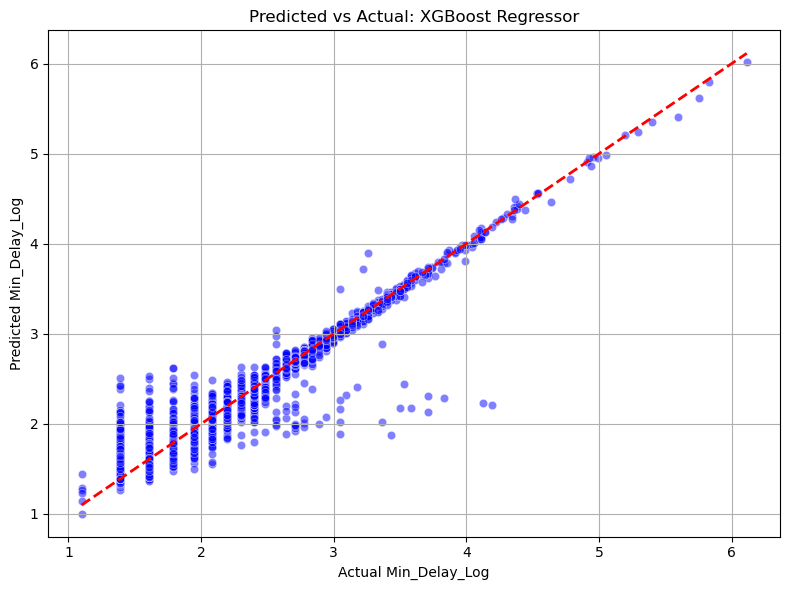

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue')

# Plot a 45-degree reference line for perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)

plt.title("Predicted vs Actual: XGBoost Regressor")
plt.xlabel("Actual Min_Delay_Log")
plt.ylabel("Predicted Min_Delay_Log")
plt.grid(True)
plt.tight_layout()
plt.show()


The XGBoost regression model delivers highly accurate predictions for the log-transformed minimum delay values (Min_Delay_Log), as indicated by a Root Mean Squared Error (RMSE) of 0.0255 and an R² score of 0.9248. The RMSE, which measures the average magnitude of prediction errors, indicates that the model’s predictions deviate from the actual values by only ~0.0255 units on the log scale — a remarkably low error given that Min_Delay_Log spans a wide range (roughly 1 to 6).

The R² score of 0.9248 suggests that the model explains over 92% of the variance in the target variable, which reflects an excellent fit, particularly for real-world transit delay data that often contains noise and irregularities. This high R² value highlights the model's effectiveness in capturing key patterns and relationships among input features such as hour of the day, station, and service characteristics.

The scatter plot of predicted vs. actual values visually reinforces these metrics. Most predictions lie close to the red dashed 45-degree line, which represents perfect prediction. This alignment confirms that the model’s outputs closely match the actual values. The few visible deviations occur mostly at lower delay values, which is expected — shorter delays are often more variable and harder to predict precisely.

SHAP Plots!

In [17]:
!pip install --upgrade shap

In [20]:
# Get preprocessor and model from pipeline
preprocessor = best_model.named_steps['preprocessing']
xgb_model = best_model.named_steps['regressor']

In [21]:
# Apply preprocessing to test set
X_test_transformed = preprocessor.transform(X_test)

# Get feature names
def get_feature_names_from_column_transformer(ct):
    output_features = []
    for name, transformer, cols in ct.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        output_features.extend(names)
    return output_features

feature_names = get_feature_names_from_column_transformer(preprocessor)


In [22]:
import shap

# Build TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed)


c:\Users\Sneha Gupta\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


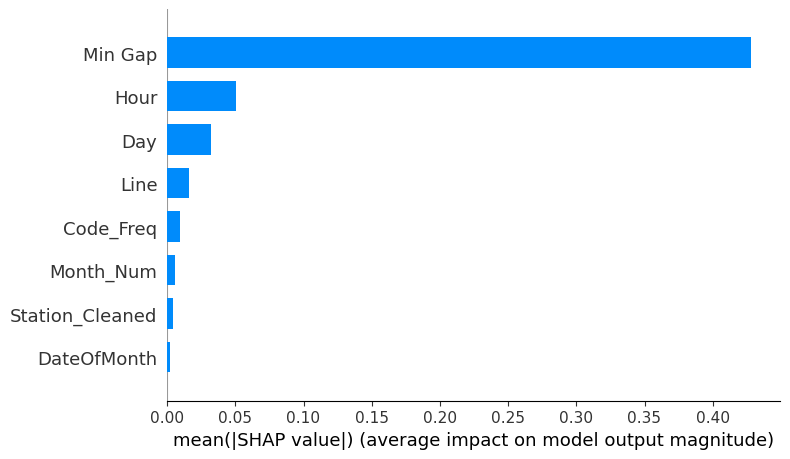

In [23]:
# Summary bar plot (global feature importance)
shap.summary_plot(shap_values, features=X_test_transformed, feature_names=feature_names, plot_type='bar')

The SHAP summary bar plot reveals that ‘Min Gap’ is by far the most influential feature in the XGBoost regression model, contributing significantly more to the model’s predictions than any other feature. Its mean SHAP value exceeds 0.40, indicating a strong average impact on the predicted log-transformed delay (Min_Delay_Log). The next most important feature, ‘Hour’, has a noticeably smaller effect, followed by ‘Day’, ‘Line’, and ‘Code_Freq’, each contributing marginally. Features like ‘Station_Cleaned’, ‘Month_Num’, and ‘DateOfMonth’ show minimal influence on the model’s output. This suggests that the timing between delays (Min Gap) is the most critical factor in estimating delay severity, while temporal or categorical metadata plays a relatively minor role in driving the model's predictions.